# CBC_ML_Pipeline
*This notebook is a complete, ready-to-run ML pipeline for the preprocessed CBC dataset.

*It trains multiple models (including XGBoost), compares them, visualizes results, and saves the best model pipeline for later predictions.


#1) Mount Google Drive

In [ ]:
print("Mounting Google Drive...")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive mounted successfully.")
except ImportError:
    print("This script is designed for Google Colab. Drive mounting skipped.")
except Exception as e:
    print(f"Error mounting Drive: {e}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully.


#2) Imports

In [ ]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SKLearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Model Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

print("All libraries imported.")

All libraries imported.


#3) Configurable Settings

In [ ]:
# DATA_PATH points to the local file you will upload to Colab.
# ** ACTION REQUIRED: Upload 'cbc_preprocessed.csv' to your Colab session! **
DATA_PATH = "/content/cbc_preprocessed.csv"

# SAVE_DIR is your specified Google Drive path.
SAVE_DIR = "/content/drive/MyDrive/ML for CBC Project"

# Paths for saved files
SAVE_PIPELINE_PATH = os.path.join(SAVE_DIR, "best_model_pipeline.joblib")
PREDICTIONS_PATH = os.path.join(SAVE_DIR, "predictions.csv")

In [ ]:
# --- Original settings (can be changed) ---
SAMPLE = None            # None = full data, or an int for faster testing (e.g., 2000)
TEST_SIZE = 0.2
RANDOM_STATE = 42
DO_GRID = False          # Set True to run light GridSearchCV (longer)
N_JOBS = -1              # parallel jobs for training (-1 uses all cores)

#4) Helper Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    """Plots a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    cm_display = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(8, 6))
    try:
        # Try using seaborn if available (common in Colab)
        import seaborn as sns
        sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues')
    except ImportError:
        # Fallback to basic matplotlib
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc(y_true_bin, y_pred_proba, classes, title):
    """Plots ROC curve for multi-class classification."""
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC - {title}')
    plt.legend(loc="lower right")
    plt.show()

print("Helper functions defined.")

Helper functions defined.


#5) Create output directories

In [ ]:
# Ensure the Google Drive save directory exists.
try:
    os.makedirs(SAVE_DIR, exist_ok=True)
    print(f"Output directory '{SAVE_DIR}' ensured.")
except Exception as e:
    print(f"WARNING: Could not create directory {SAVE_DIR}. Error: {e}")
    print("Please ensure the path is correct and Drive is mounted.")

Output directory '/content/drive/MyDrive/ML for CBC Project' ensured.


#6) Load Data

In [ ]:
print(f"Loading data from {DATA_PATH}...")
try:
    df = pd.read_csv(DATA_PATH)
    if SAMPLE:
        print(f"Sampling data to {SAMPLE} rows for testing.")
        df = df.sample(n=SAMPLE, random_state=RANDOM_STATE)

    print("Data loaded successfully.")
    print(f"Shape: {df.shape}")
    print(df.head())
except FileNotFoundError:
    print(f"---!!! ERROR: File not found at {DATA_PATH} !!!---")
    print(">>> PLEASE UPLOAD 'cbc_preprocessed.csv' TO THE COLAB SESSION (left-side 'Files' tab) AND TRY AGAIN. <<<")
    # Stop execution if file isn't found
    raise
except Exception as e:
    print(f"An error occurred loading the data: {e}")
    raise

Loading data from /content/cbc_preprocessed.csv...
Data loaded successfully.
Shape: (49943, 23)
        WBC       LY%       MO%       NE%       EO%   BA%       LY#       MO#       NE#  EO#  BA#       RBC       HGB       HCT       MCV      MCHC       MCH  RDW       PLT       MPV       NLR  Anemia_Flag      Target
0  0.259259 -0.823529 -0.241379  0.707792  0.869565 -0.25 -0.545455  0.000000  0.590909  0.5  0.0  0.140625  0.142857  0.222222  0.053333 -0.333333 -0.111111  1.2 -0.574468 -0.181818  1.199687          0.0      normal
1  0.222222  0.404412  0.103448 -1.097403  5.434783 -0.75  0.545455  0.333333 -0.409091  4.5  0.0 -0.187500 -0.047619 -0.174603 -0.160000  0.666667  0.111111 -0.8  0.021277  0.636364 -0.575536          0.0      normal
2  0.703704  1.867647 -0.551724 -2.064935  3.913043  0.00  2.636364  0.000000 -0.772727  4.0  1.0  0.203125 -2.142857 -1.746032 -3.546667 -2.000000 -3.925926  2.8  2.159574 -0.090909 -1.090294          1.0  microcytic
3 -0.370370  0.404412 -0.551724 

#7) Label Encoding (Target)

In [ ]:
print("Encoding target variable...")
target_col = "Target"

# --- FIX: Ensure alignment and handle NaNs ---
# Drop any rows where the 'Target' column is empty
print(f"Original shape before dropping NaNs in Target: {df.shape}")
df.dropna(subset=[target_col], inplace=True)
print(f"Shape after dropping NaNs in Target: {df.shape}")

# Now, create and fit the LabelEncoder
le = LabelEncoder()
try:
    # Create a new column 'Target_Encoded' in the DataFrame
    df['Target_Encoded'] = le.fit_transform(df[target_col])

    # Store classes for later
    classes = le.classes_
    print(f"Target column '{target_col}' encoded.")
    print(f"Found {len(classes)} classes: {classes}")

except KeyError:
    print(f"ERROR: Target column '{target_col}' not found in the data.")
    print(f"Available columns: {df.columns.tolist()}")
    raise

Encoding target variable...
Original shape before dropping NaNs in Target: (49943, 23)
Shape after dropping NaNs in Target: (49942, 23)
Target column 'Target' encoded.
Found 6 classes: ['Leukemia' 'Thrombocytopenia' 'macrocytic' 'microcytic' 'normal'
 'normocytic']


#8) Define Features (X) and Target (y) (MODIFIED)

In [ ]:
# Define columns to drop:
# - 'Target' (it's the original text output)
# - 'Target_Encoded' (it's the numeric output we want to predict)
# - 'Anemia_Flag' (it's related to the target and would cause data leakage)
cols_to_drop = ["Target", "Anemia_Flag", "Target_Encoded"]

try:
    # X is our DataFrame of features
    X = df.drop(columns=cols_to_drop, errors='ignore')

    # y is our pandas Series for the target
    y = df['Target_Encoded']

    # anemia_flag_data is also a pandas Series
    if 'Anemia_Flag' in df.columns:
        anemia_flag_data = df['Anemia_Flag']
    else:
        # Create a placeholder if it doesn't exist
        anemia_flag_data = pd.Series([None] * len(X), index=X.index)

    # Store feature names for later use
    feature_columns = X.columns.tolist()

    print("Features (X) and Target (y) defined as pandas objects.")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"Dropped columns: {cols_to_drop}")

except Exception as e:
    print(f"ERROR: Could not define X and y. Error: {e}")
    raise

Features (X) and Target (y) defined as pandas objects.
X shape: (49942, 21), y shape: (49942,)
Dropped columns: ['Target', 'Anemia_Flag', 'Target_Encoded']


#9) Train/Test Split

In [ ]:
# --- 9.1) Filter Rare Classes (Fix for ValueError) ---
print("Filtering out classes with only 1 sample...")

# Count how many times each encoded class appears
class_counts = y.value_counts()

# Get a list of classes that appear 2 or more times
valid_classes = class_counts[class_counts >= 2].index

# Create a boolean mask from our 'y' Series
mask = y.isin(valid_classes)

# Apply the *same mask* to X, y, and anemia_flag_data
# Because they are all pandas objects with the same index, this is safe.
X_filtered = X[mask]
y_filtered = y[mask]
anemia_flag_data_filtered = anemia_flag_data[mask]

print(f"Removed {len(X) - len(X_filtered)} samples from 1-member classes.")

# --- 9.2) Train/Test Split ---
print(f"Splitting filtered data into train/test sets (Test size: {TEST_SIZE})...")

# We use the new _filtered variables.
X_train, X_test, y_train, y_test, anemia_flag_train, anemia_flag_test = train_test_split(
    X_filtered,
    y_filtered,
    anemia_flag_data_filtered,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_filtered  # Stratify by the filtered y Series
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Final check
if len(X_train) == len(y_train) and len(X_test) == len(y_test):
    print("Train/Test split successful. Lengths are consistent.")
else:
    print("--- FATAL ERROR: Split resulted in mismatched lengths! ---")
    raise Exception("Train/Test split error.")

Filtering out classes with only 1 sample...
Removed 0 samples from 1-member classes.
Splitting filtered data into train/test sets (Test size: 0.2)...
X_train shape: (39953, 21), y_train shape: (39953,)
X_test shape: (9989, 21), y_test shape: (9989,)
Train/Test split successful. Lengths are consistent.


#10) Preprocessing & Model Pipeline (MODIFIED)

In [ ]:
print("Defining model pipelines (without scaling)...")

# This pipeline step will just fill any missing values with the median.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
preprocessor = numeric_transformer

# --- Define Models ---
models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1,
                             objective='multi:softprob',
                             num_class=len(classes),
                             eval_metric='mlogloss')
}

# --- Define Pipelines ---
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

print("Pipelines created:")
print(list(pipelines.keys()))

Defining model pipelines (without scaling)...
Pipelines created:
['LogisticRegression', 'RandomForest', 'XGBoost']


#11) Train & Evaluate Models


--- Starting Model Training & Evaluation ---

Training LogisticRegression...
--- Results for LogisticRegression ---
Accuracy: 0.9537
AUC (micro-avg): 0.9982
Classification Report:
                  precision    recall  f1-score   support

        Leukemia       0.72      0.99      0.83       503
Thrombocytopenia       0.53      1.00      0.70       154
      macrocytic       0.67      1.00      0.80        12
      microcytic       0.85      0.99      0.92       332
          normal       1.00      0.95      0.97      8515
      normocytic       0.87      0.98      0.92       473

        accuracy                           0.95      9989
       macro avg       0.77      0.99      0.86      9989
    weighted avg       0.97      0.95      0.96      9989



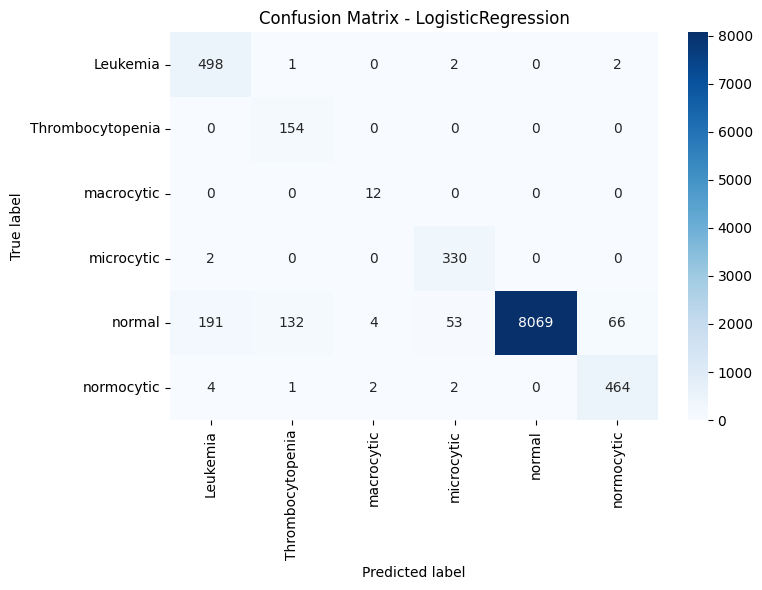

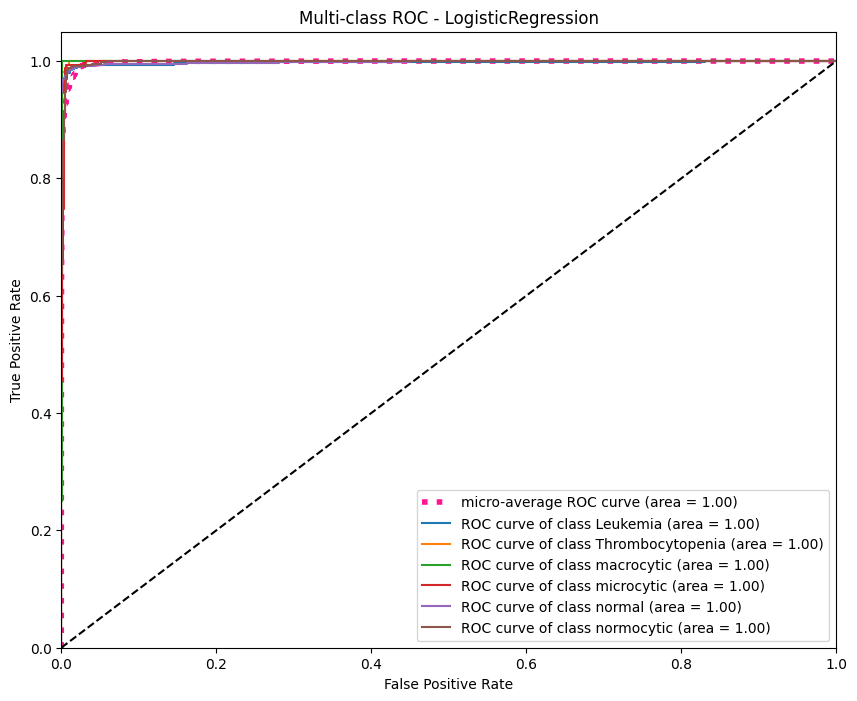


Training RandomForest...
--- Results for RandomForest ---
Accuracy: 0.9999
AUC (micro-avg): 1.0000
Classification Report:
                  precision    recall  f1-score   support

        Leukemia       1.00      1.00      1.00       503
Thrombocytopenia       1.00      1.00      1.00       154
      macrocytic       1.00      0.92      0.96        12
      microcytic       1.00      1.00      1.00       332
          normal       1.00      1.00      1.00      8515
      normocytic       1.00      1.00      1.00       473

        accuracy                           1.00      9989
       macro avg       1.00      0.99      0.99      9989
    weighted avg       1.00      1.00      1.00      9989



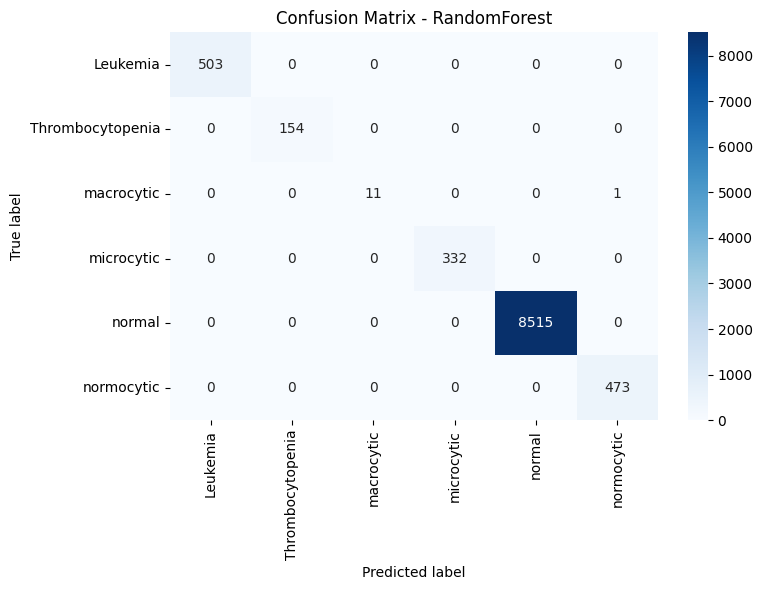

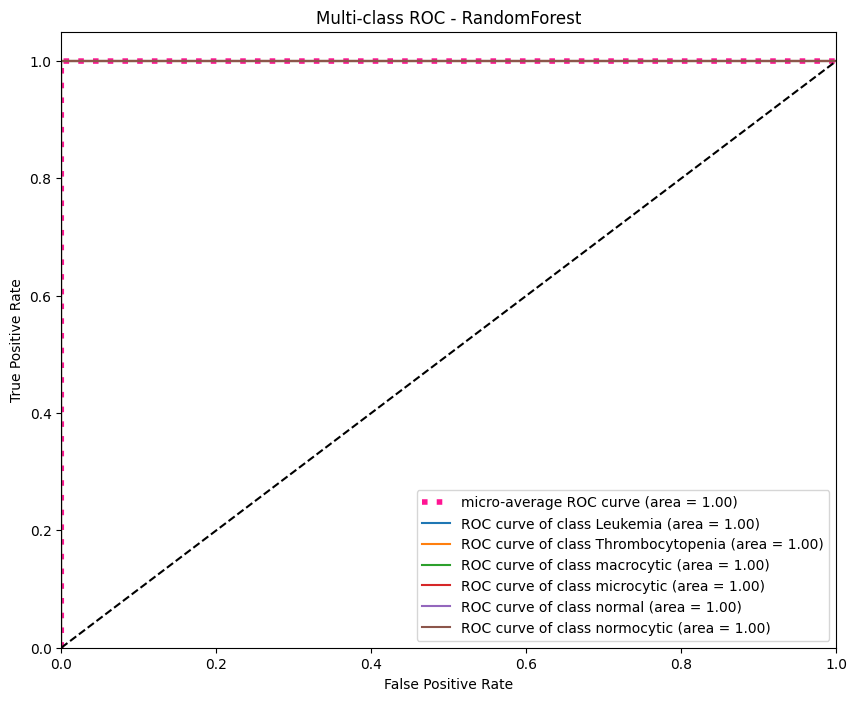


Training XGBoost...
--- Results for XGBoost ---
Accuracy: 0.9979
AUC (micro-avg): 1.0000
Classification Report:
                  precision    recall  f1-score   support

        Leukemia       1.00      1.00      1.00       503
Thrombocytopenia       0.93      0.97      0.95       154
      macrocytic       1.00      0.92      0.96        12
      microcytic       0.99      1.00      0.99       332
          normal       1.00      1.00      1.00      8515
      normocytic       1.00      0.99      0.99       473

        accuracy                           1.00      9989
       macro avg       0.99      0.98      0.98      9989
    weighted avg       1.00      1.00      1.00      9989



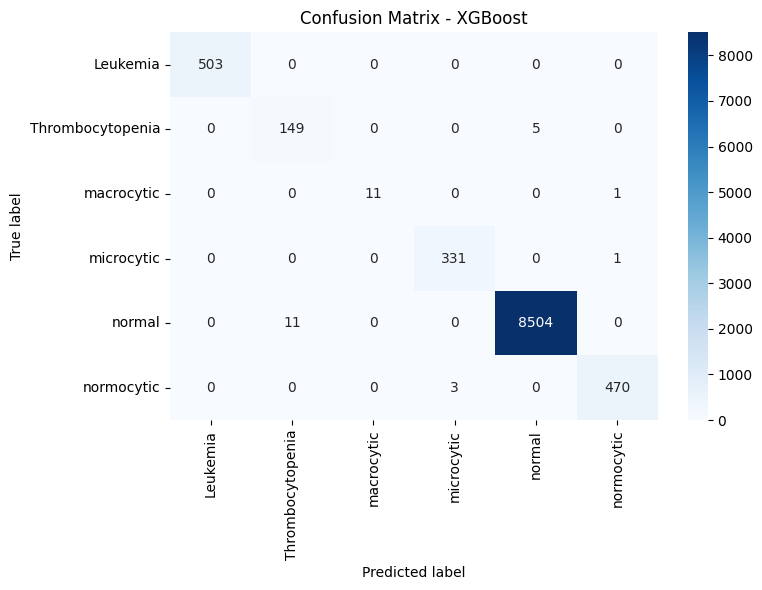

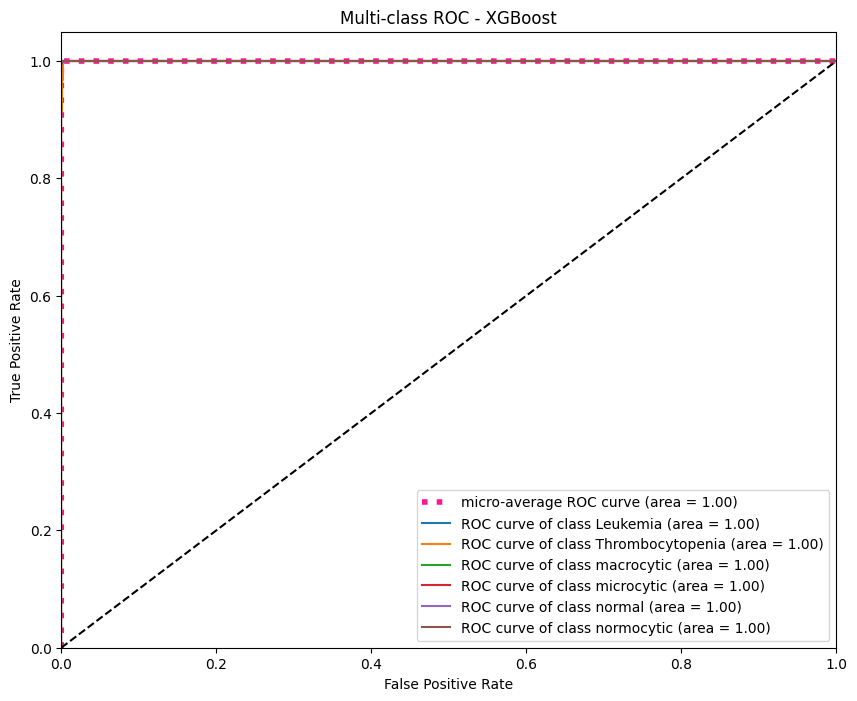


--- Model Comparison ---
LogisticRegression: Accuracy = 0.9537, AUC = 0.9981974485679367
RandomForest: Accuracy = 0.9999, AUC = 0.999999859691491
XGBoost: Accuracy = 0.9979, AUC = 0.9999979053944021


In [ ]:
print("\n--- Starting Model Training & Evaluation ---")
best_score = -1.0
best_model = None
best_name = ""
best_pipeline = None
results = {}

# Use the full filtered 'y' from Cell 9 for binarizer fitting
y_full_filtered = y_filtered

for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")
    try:
        # Train the model
        pipe.fit(X_train, y_train)

        # Make predictions
        y_pred = pipe.predict(X_test)

        # Get prediction probabilities
        y_pred_proba = None
        if hasattr(pipe, "predict_proba"):
            y_pred_proba = pipe.predict_proba(X_test)
            if len(classes) == 2:
                auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                # Use the full 'y' to ensure all classes are known to the binarizer
                y_test_bin = LabelBinarizer().fit(y_full_filtered).transform(y_test)
                auc_score = roc_auc_score(y_test_bin, y_pred_proba, average='micro', multi_class='ovr')
        else:
            auc_score = None

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=classes, labels=range(len(classes)), zero_division=0)

        results[name] = {'accuracy': accuracy, 'auc': auc_score, 'report': report, 'model_object': pipe['model']}

        print(f"--- Results for {name} ---")
        print(f"Accuracy: {accuracy:.4f}")
        if auc_score:
            print(f"AUC (micro-avg): {auc_score:.4f}")
        print("Classification Report:")
        print(report)

        # Plot visualizations
        plot_confusion_matrix(y_test, y_pred, classes=classes, title=f'Confusion Matrix - {name}')

        if y_pred_proba is not None and len(classes) > 2:
            y_test_bin_plot = LabelBinarizer().fit(y_full_filtered).transform(y_test)
            plot_multiclass_roc(y_test_bin_plot, y_pred_proba, classes=classes, title=name)
        elif y_pred_proba is not None and len(classes) == 2:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
            roc_auc_val = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_val:0.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc="lower right")
            plt.show()

        # Check for best model
        current_score = auc_score if auc_score is not None else accuracy
        if current_score > best_score:
            best_score = current_score
            best_model = pipe['model']
            best_name = name
            best_pipeline = pipe

    except Exception as e:
        print(f"ERROR: Failed to train {name}. Error: {e}")

print("\n--- Model Comparison ---")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['accuracy']:.4f}, AUC = {res.get('auc', 'N/A')}")

--- Running Leakage Diagnostic on Best Model (RandomForest) ---

Top 10 Most Important Features:
   feature  importance
14     MCV    0.162364
18     PLT    0.158977
12     HGB    0.141351
0      WBC    0.104615
11     RBC    0.101346
16     MCH    0.097014
13     HCT    0.073146
8      NE#    0.046456
6      LY#    0.020546
19     MPV    0.015806


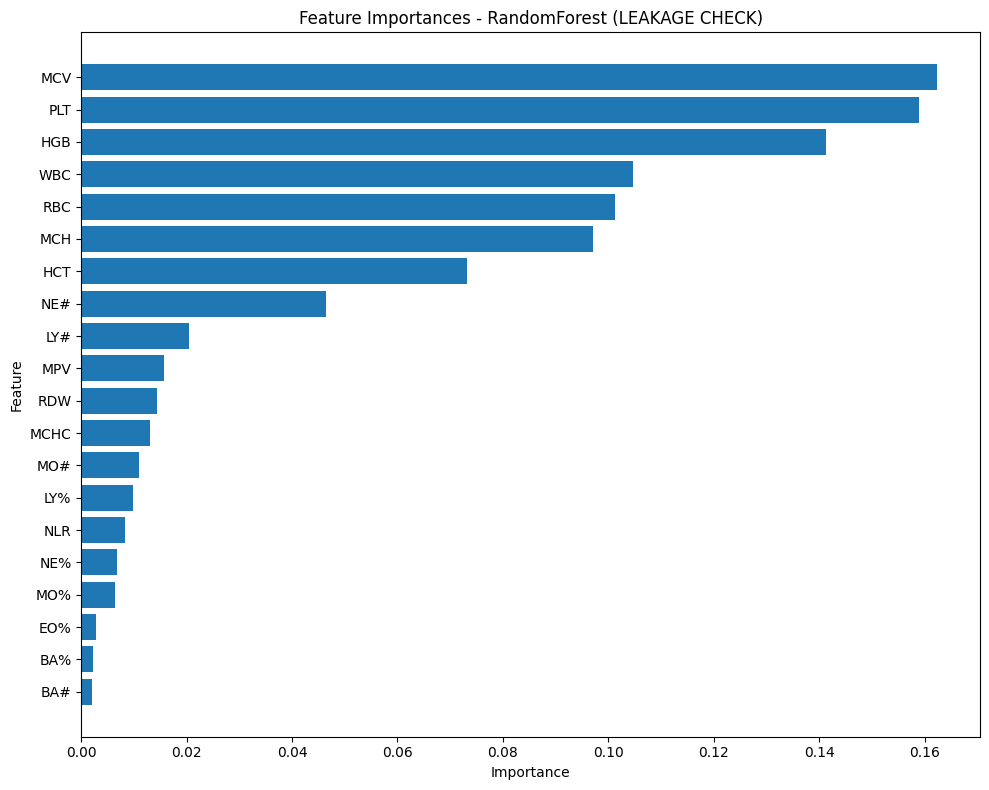


--- INTERPRETATION ---
Look at the plot above. Is one feature's importance value EXTREMELY high (e.g., > 0.8) while all others are near 0?
If so, that is your 'leaky' column. We must remove it.


In [ ]:
# ----------------- 11.5) DIAGNOSTIC: Check for Data Leakage -----------------
print(f"--- Running Leakage Diagnostic on Best Model ({best_name}) ---")

# Check if the best model has feature importances (RandomForest/XGBoost do)
if hasattr(best_model, 'feature_importances_'):
    fi = best_model.feature_importances_

    # Create a DataFrame of features and their importance scores
    fi_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': fi
    }).sort_values(by='importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(fi_df.head(10))

    # Plot the top 20 features
    plt.figure(figsize=(10, 8))
    plt.title(f"Feature Importances - {best_name} (LEAKAGE CHECK)")
    top_20_features = fi_df.head(20)
    plt.barh(top_20_features['feature'][::-1], top_20_features['importance'][::-1])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    print("\n--- INTERPRETATION ---")
    print("Look at the plot above. Is one feature's importance value EXTREMELY high (e.g., > 0.8) while all others are near 0?")
    print("If so, that is your 'leaky' column. We must remove it.")

else:
    print(f"The best model ({best_name}) does not support 'feature_importances_'.")

#12) Save Best Model & Predictions (MODIFIED)


Best model is: RandomForest with score: 1.0000
Successfully saved best model pipeline to: /content/drive/MyDrive/ML for CBC Project/best_model_pipeline.joblib
Successfully saved test predictions (with Anemia_Flag) to: /content/drive/MyDrive/ML for CBC Project/predictions.csv

Prediction file head:
            WBC       LY%       MO%       NE%       EO%   BA%       LY#       MO#       NE#  EO#  BA#       RBC       HGB       HCT       MCV      MCHC       MCH  RDW       PLT       MPV       NLR  Anemia_Flag_True  Target_True_Encoded Target_True_Label  Target_Pred_Encoded Target_Pred_Label
39553  0.148148 -0.676471  4.000000 -0.090909 -0.086957  0.50 -0.454545  3.000000  0.090909  0.0  1.0 -0.062500  0.238095  0.317460  0.560000 -0.166667  0.407407  1.6  0.031915  0.636364  0.511176               0.0                    4            normal                    4            normal
1656   0.814815 -0.419118  0.206897  0.409091  0.043478 -0.75  0.181818  1.000000  0.863636  0.0  0.0 -0.421875 -0

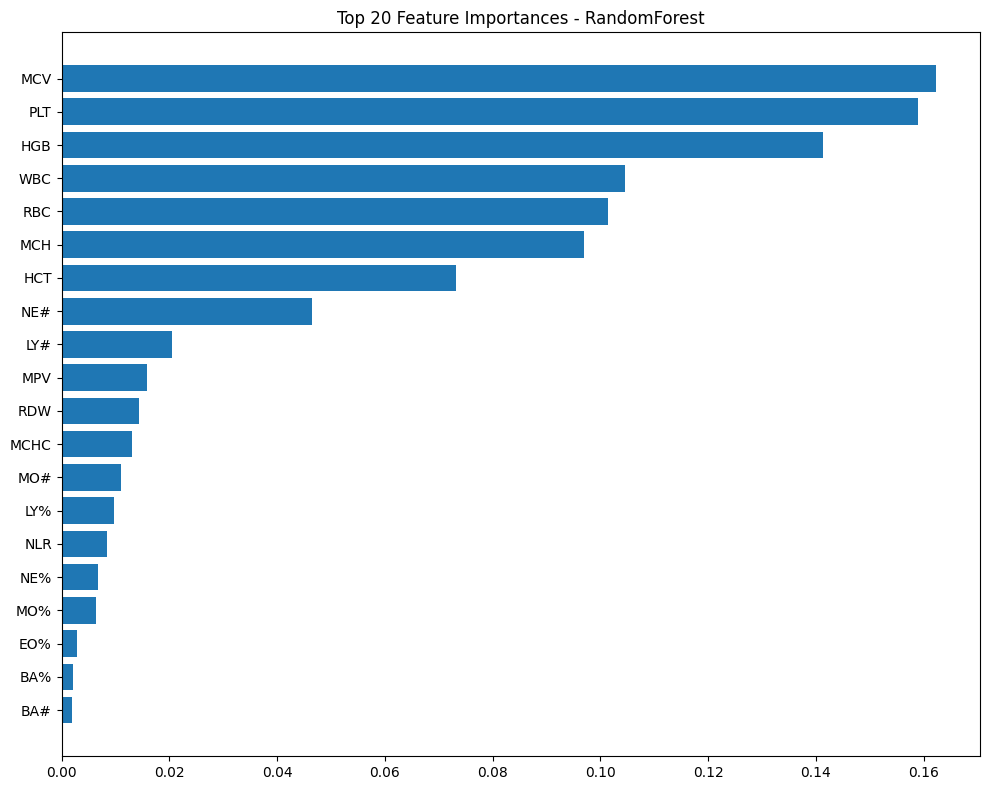


--- Pipeline Complete ---


In [ ]:
print(f"\nBest model is: {best_name} with score: {best_score:.4f}")

if best_pipeline:
    try:
        # Create a dictionary to save
        save_data = {
            'pipeline': best_pipeline,
            'label_encoder': le,
            'feature_columns': feature_columns
            # MODIFIED: Removed scaler as it's not used
        }

        joblib.dump(save_data, SAVE_PIPELINE_PATH)
        print(f"Successfully saved best model pipeline to: {SAVE_PIPELINE_PATH}")

        # Save test predictions
        # Create a DataFrame with test features
        test_preds_df = pd.DataFrame(X_test, columns=feature_columns)

        # Add the 'Anemia_Flag' column back for comparison
        test_preds_df['Anemia_Flag_True'] = anemia_flag_test.values

        # Add True and Predicted Target values
        test_preds_df['Target_True_Encoded'] = y_test
        test_preds_df['Target_True_Label'] = le.inverse_transform(y_test)
        test_preds_df['Target_Pred_Encoded'] = best_pipeline.predict(X_test)
        test_preds_df['Target_Pred_Label'] = le.inverse_transform(test_preds_df['Target_Pred_Encoded'])

        # Save the predictions DataFrame to CSV
        test_preds_df.to_csv(PREDICTIONS_PATH, index=False)
        print(f"Successfully saved test predictions (with Anemia_Flag) to: {PREDICTIONS_PATH}")

        print("\nPrediction file head:")
        print(test_preds_df.head())

    except Exception as e:
        print(f"ERROR saving model or predictions: {e}")
        print(f"Please check write permissions for your Drive folder: {SAVE_DIR}")

# --- Feature importances (if available) ---
if hasattr(best_model, 'feature_importances_'):
    print("\nDisplaying Feature Importances for best model...")
    fi = best_model.feature_importances_
    feat_df = pd.DataFrame({'feature': X.columns, 'importance': fi}).sort_values('importance', ascending=False)
    print(feat_df.head(20))

    # Plot importances
    plt.figure(figsize=(10, 8))
    plt.barh(feat_df['feature'].iloc[:20][::-1], feat_df['importance'].iloc[:20][::-1])
    plt.title('Top 20 Feature Importances - ' + best_name)
    plt.tight_layout()
    plt.show()

print("\n--- Pipeline Complete ---")

#13) Prediction Helper (MODIFIED)

In [ ]:
#
# After running the notebook and saving the pipeline, you can use the following
# code in a *new* Colab notebook to load and use your model for new predictions.
#
"""
# === Example: How to Load and Predict in a New Notebook ===

import joblib
import pandas as pd
import os

# 1. Mount your Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not in Colab. Skipping Drive mount.")

# 2. Define the path to your saved model
SAVE_DIR = "/content/drive/MyDrive/ML for CBC Project"
SAVE_PIPELINE_PATH = os.path.join(SAVE_DIR, "best_model_pipeline.joblib")

# 3. Load the saved data dictionary
try:
    saved_data = joblib.load(SAVE_PIPELINE_PATH)

    # Extract the components
    pipe = saved_data['pipeline']
    le = saved_data['label_encoder']
    cols = saved_data['feature_columns']

    print("Model pipeline loaded successfully.")

    # 4. Create a helper function for prediction
    def predict_new_samples(sample_data):
        # sample_data: Can be a dictionary of {feature: value}
        #                or a DataFrame with all feature columns

        # Convert dictionary to DataFrame if needed
        if isinstance(sample_data, dict):
            X_new = pd.DataFrame([sample_data])
        else:
            X_new = sample_data.copy()

        # Ensure columns are in the correct order
        X_new = X_new[cols]

        # The pipeline 'pipe' contains the imputer AND the model.
        # We just call .predict() and .predict_proba() on the full pipeline.

        # Predict encoded label
        pred_encoded = pipe.predict(X_new)
        # Decode to original label
        pred_label = le.inverse_transform(pred_encoded)

        # Get probabilities for each class
        pred_proba = pipe.predict_proba(X_new)

        # Format probabilities nicely
        proba_df = pd.DataFrame(pred_proba, columns=le.classes_)

        return pred_label, proba_df

    # 5. Example Prediction:
    # IMPORTANT: You must provide values for ALL features the model was trained on.
    # (These are example values, replace with real data)

    example_sample = {
        'WBC': 0.25, 'LY%': -0.82, 'MO%': -0.24, 'NE%': 0.70, 'EO%': 0.86,
        'BA%': -0.24, 'LY#': -0.54, 'MO#': 0.0, 'NE#': 0.59, 'EO#': 0.49,
        'BA#': 0.0, 'RBC': 0.14, 'HGB': 0.14, 'HCT': 0.22, 'MCV': 0.05,
        'MCHC': -0.33, 'MCH': -0.11, 'RDW': 1.19, 'PLT': -0.11, 'MPV': 0.9,
        'NLR': -0.45
        # ... add all other feature columns from 'feature_columns' list
    }

    # Check if all columns are present (this is a simple check)
    if len(example_sample.keys()) != len(cols):
        print(f"Warning: Example sample has {len(example_sample.keys())} features, but model needs {len(cols)}.")
    else:
        # Make prediction
        label, probabilities = predict_new_samples(example_sample)

        print("\n--- Example Prediction ---")
        print(f"Predicted Label: {label[0]}")
        print("Prediction Probabilities:")
        print(probabilities)

except FileNotFoundError:
    print(f"ERROR: Model file not found at {SAVE_PIPELINE_PATH}")
    print("Please ensure the path is correct and the model file exists.")
except Exception as e:
    print(f"An error occurred loading the model: {e}")

"""